#. DATA정보정리
pclass : passenger Class 승객등급
survuved : 생존여부 (생존1, 사망0)
name : 이름
sex : 성별
sibsp : 동승한 형제 또는 배우자 수
parch : 동승한 보모 또는 자녀 수
ticket : 티켓 번호
fare : 승객 지불 요금
cabin : 선실 이름
embarked : 승선항(c = 쉘부르크, Q= 퀸즈타운, S=사우스 햄튼)
body : 사망자 확인 번호
bome.dest : 고향/목적지

In [302]:
from tensorflow.python.client import device_lib 
device_lib.list_local_devices()

ModuleNotFoundError: No module named 'catboost'

In [312]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier # 유명한 randomforestclassfier 입니다. 
from sklearn import metrics # 모델의 평가를 위해서 씁니다

import warnings
warnings.simplefilter('ignore')

df_train = pd.read_csv("input/train.csv")
df_test = pd.read_csv("input/test.csv")
df_train.head()
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,1,2,"Bell, Adele",female,62.00,0,0,PC 15008,14.86,D17243,C
99996,99996,0,2,"Brown, Herman",male,66.00,0,0,13273,11.15,NaN,S
99997,99997,0,3,"Childress, Charles",male,37.00,0,0,NaN,9.95,NaN,S
99998,99998,0,3,"Caughlin, Thomas",male,51.00,0,1,458654,30.92,NaN,S


In [313]:
df_test.head()
#survived 여부 

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
1,100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
2,100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
3,100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
4,100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C


In [314]:
print(df_train.info())
print("======================================")
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          96708 non-null   float64
 6   SibSp        100000 non-null  int64  
 7   Parch        100000 non-null  int64  
 8   Ticket       95377 non-null   object 
 9   Fare         99866 non-null   float64
 10  Cabin        32134 non-null   object 
 11  Embarked     99750 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 9.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 

In [315]:
df_train.isnull().sum()

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age             3292
SibSp              0
Parch              0
Ticket          4623
Fare             134
Cabin          67866
Embarked         250
dtype: int64

In [316]:
#피처 제거
df_train = df_train.drop(['Name', 'Ticket', 'Cabin'], axis = 1)
df_train #100000 rows × 9 columns
# sns.heatmap(df_train, cmap='viridis')
# plt.show()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,1,1,male,NaN,2,0,27.14,S
1,1,0,3,male,NaN,0,0,13.35,S
2,2,0,3,male,0.33,1,2,71.29,S
3,3,0,3,male,19.00,0,0,13.04,S
4,4,1,3,male,25.00,0,0,7.76,S
...,...,...,...,...,...,...,...,...,...
99995,99995,1,2,female,62.00,0,0,14.86,C
99996,99996,0,2,male,66.00,0,0,11.15,S
99997,99997,0,3,male,37.00,0,0,9.95,S
99998,99998,0,3,male,51.00,0,1,30.92,S


In [317]:
#age결측 채우기
mean = df_train['Age'].mean()
num = 0
for i in df_train['Age'] :
    if np.isnan(i) : 
        df_train['Age'][num] = mean
    num +=1
df_train['Age']

0        38.355472
1        38.355472
2         0.330000
3        19.000000
4        25.000000
           ...    
99995    62.000000
99996    66.000000
99997    37.000000
99998    51.000000
99999    55.000000
Name: Age, Length: 100000, dtype: float64

In [318]:
#Embarked 결측 채우기 250개
df_train['Embarked'].value_counts()

S    72139
C    22187
Q     5424
Name: Embarked, dtype: int64

In [319]:
num = 0
for i in df_train['Embarked'] :
     if type(i) == float :
        df_train['Embarked'][num] = 'S'
     num += 1
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age              0
SibSp            0
Parch            0
Fare           134
Embarked         0
dtype: int64

In [320]:
#Fare 결측 채우기 134개
mean = df_train['Fare'].mean()
num = 0
for i in df_train['Fare'] :
    if np.isnan(i) : 
        df_train['Fare'][num] = mean
    num +=1
df_train['Fare']

0        27.14
1        13.35
2        71.29
3        13.04
4         7.76
         ...  
99995    14.86
99996    11.15
99997     9.95
99998    30.92
99999    13.96
Name: Fare, Length: 100000, dtype: float64

In [321]:
df_train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [322]:
df_train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,1,1,male,38.355472,2,0,27.14,S
1,1,0,3,male,38.355472,0,0,13.35,S
2,2,0,3,male,0.330000,1,2,71.29,S
3,3,0,3,male,19.000000,0,0,13.04,S
4,4,1,3,male,25.000000,0,0,7.76,S
...,...,...,...,...,...,...,...,...,...
99995,99995,1,2,female,62.000000,0,0,14.86,C
99996,99996,0,2,male,66.000000,0,0,11.15,S
99997,99997,0,3,male,37.000000,0,0,9.95,S
99998,99998,0,3,male,51.000000,0,1,30.92,S


In [323]:
df_train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [324]:
#그래프 함수 정의
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams['axes.grid'] = True 

def bar_chart(feature) :
    survived = df_train[df_train['Survived'] == 1][feature].value_counts()
    dead = df_train[df_train['Survived'] == 0][feature].value_counts()
    df = pd.DataFrame([survived, dead])
    df.index = ['survived', 'dead']
    df.plot(kind = 'bar', stacked = True)

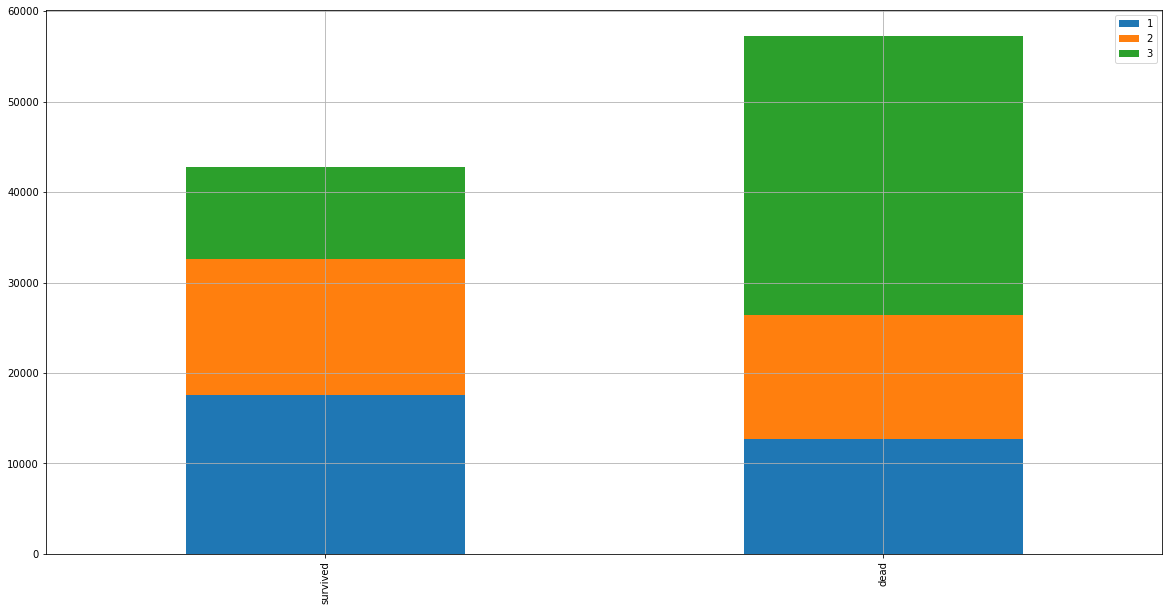

In [325]:
#Survived  /// Pclass
bar_chart('Pclass') #1등석 산 비중 높음

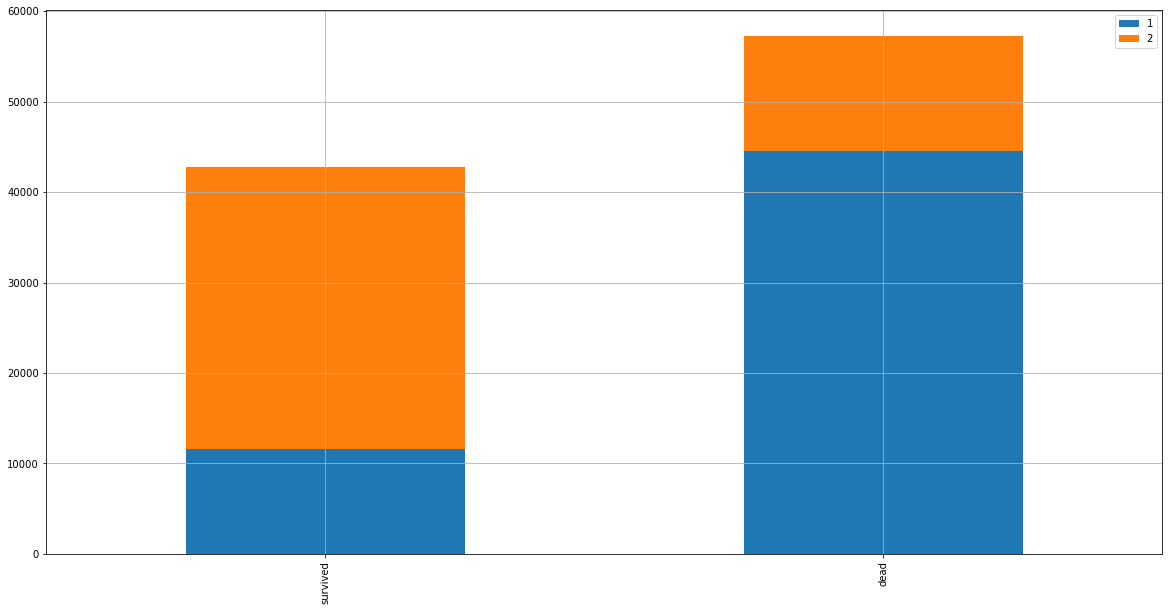

In [326]:
#데이터 숫자 변환 #남여 남 = 1, 여자 = 2
df_train.loc[df_train['Sex'] == 'male', 'Sex'] = 1
df_train.loc[df_train['Sex'] == 'female', 'Sex'] = 2
bar_chart('Sex') # -- 여자가 많이 산 듯함.

In [327]:
#연령
df_train.loc[df_train['Age'] <=20, 'Age'] = 0
df_train.loc[(df_train['Age'] <=40)&(df_train['Age'] >20), 'Age'] = 1
df_train.loc[(df_train['Age'] <=60)&(df_train['Age'] >40), 'Age'] = 2
df_train.loc[(df_train['Age'] <=80)&(df_train['Age'] >60), 'Age'] = 3
df_train.loc[df_train['Age'] > 80] = 4

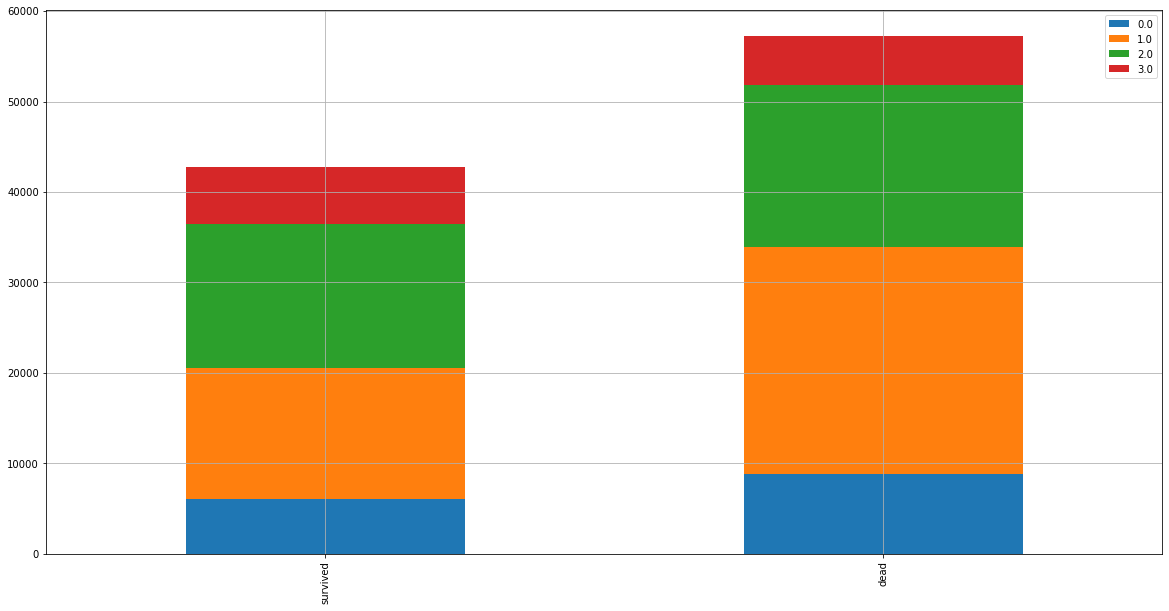

In [328]:
bar_chart('Age') #80살 이상 없음 20~60세

In [329]:
#상관관계 분석
#데이터 숫자 변환 #칸 등급
df_train.loc[df_train['Embarked'] == 'S', 'Embarked'] = 1
df_train.loc[df_train['Embarked'] == 'C', 'Embarked'] = 2
df_train.loc[df_train['Embarked'] == 'Q', 'Embarked'] = 3

#동승자 데이터 합
df_train['Family'] = df_train['SibSp'] + df_train['Parch']
df_train = df_train.drop(['SibSp', 'Parch'], axis = 1)

In [330]:
df_train.corr(method='pearson')

,PassengerId,Survived,Pclass,Age,Fare,Family
PassengerId,1.000000,-0.003989,-0.002724,-0.004726,-0.000571,-0.003353
Survived,-0.003989,1.000000,-0.278184,0.107900,0.183292,0.028163
Pclass,-0.002724,-0.278184,1.000000,-0.228479,-0.417156,-0.053755
Age,-0.004726,0.107900,-0.228479,1.000000,0.095339,-0.124221
Fare,-0.000571,0.183292,-0.417156,0.095339,1.000000,0.075646
Family,-0.003353,0.028163,-0.053755,-0.124221,0.075646,1.000000


<AxesSubplot:>

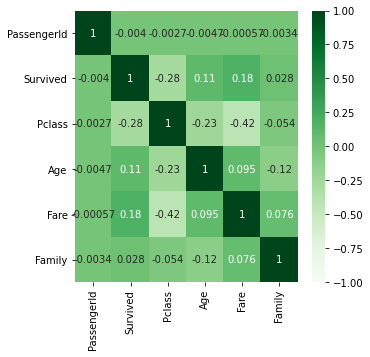

In [331]:
#heatmap
plt.rcParams['figure.figsize'] = (5,5)
sns.heatmap(df_train.corr(),
           annot = True, #실제값 화면에 나타내기
           cmap = 'Greens', #색
           vmin = -1, vmax = 1 #컬러차트 영역 -1 ~ _1
           )

In [332]:
print(df_train.shape)
print(df_test.shape)

(100000, 8)
(100000, 11)


In [333]:
#1.2 DATA
x_pred = df_test
X = df_train.loc[:, df_train.columns != 'Survived']
Y = df_train['Survived']

In [334]:
print(X.shape)
print(Y.shape)
print(Y)

(100000, 7)
(100000,)
0        1
1        0
2        0
3        0
4        1
        ..
99995    1
99996    0
99997    0
99998    0
99999    0
Name: Survived, Length: 100000, dtype: int64


In [335]:
#1.3 정규화
from sklearn.preprocessing import LabelEncoder, StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(X)
X = scaler.transform(X)
print(X.shape)

(100000, 7)


In [357]:
X = np.array(X)
print(X.shape)
Y

(100000, 7)


0        1
1        0
2        0
3        0
4        1
        ..
99995    1
99996    0
99997    0
99998    0
99999    0
Name: Survived, Length: 100000, dtype: int64